<a href="https://colab.research.google.com/github/Crltt/GCA-ROM-DG/blob/main/notebook/242_maxelldg00625_TEz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and import gca-rom
!git clone https://github.com/Crltt/GCA-ROM-DG.git
import sys
sys.path.append('GCA-ROM-DG')
from gca_rom_dg import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


fatal: destination path 'GCA-ROM-DG' already exists and is not an empty directory.


In [4]:
import numpy as np
from itertools import product

# Define PDE problem
For the description of the model and generation of the dataset look at: Hesthaven, Jan & Warburton, Tim. (2007). Nodal Discontinuous Galerkin Methods: Algorithms, Analysis, and Applications (https://github.com/tcew/nodal-dg.git)

In [5]:
problem_name, variable, mu_space, n_param = pde.problem(24)
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Parameters: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)
HyperParams = network.HyperParams(argv)


Problem:  maxwelldg00625p1hp
Variable:  TEz
Parameters:  1


# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cuda


# Load dataset

In [7]:
dataset_dir = 'GCA-ROM-DG/dataset/'+problem_name+'_unstructured.mat'
dataset = loader.LoadDataset(dataset_dir, variable)

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, coordxyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories = preprocessing.graphs_dataset(dataset, HyperParams)

params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)

num_nodes:  2310
num_graphs:  245
Length of train dataset:  98
Length of test dataset:  147


# Define the architecture

In [8]:
model = network.Net(HyperParams)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HyperParams.learning_rate, weight_decay=HyperParams.weight_decay, foreach=False)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

input size:  2310


# Train or load a pre-trained network

In [9]:
try:
    model.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'.pt', map_location=torch.device('cuda')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model, optimizer, device, scheduler, params, train_loader, test_loader, train_trajectories, test_trajectories, HyperParams)

Loading saved network


# Evaluate the model

In [10]:
model.to("cpu")
params = params.to("cpu")
vars = "GCA-ROM-DG"
results, latents_map, latents_gca = testing.evaluate(VAR_all, model, dataset, graph_loader, params, HyperParams, range(params.shape[0]))

100%|██████████| 245/245 [00:07<00:00, 34.69it/s]


# Plot the results

100%|██████████| 147/147 [00:01<00:00, 87.13it/s]


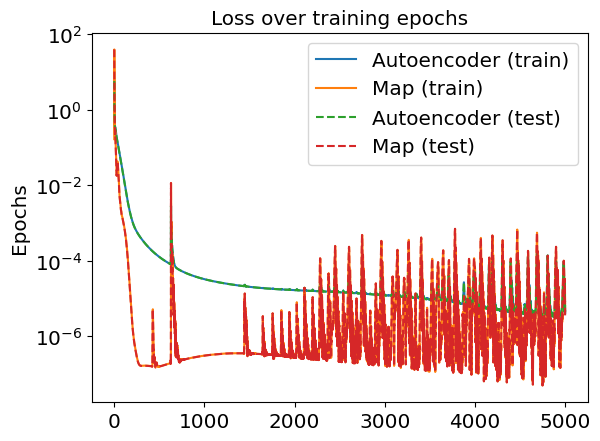

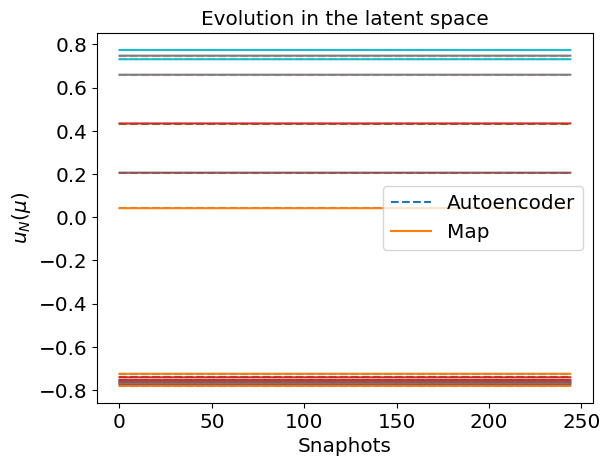

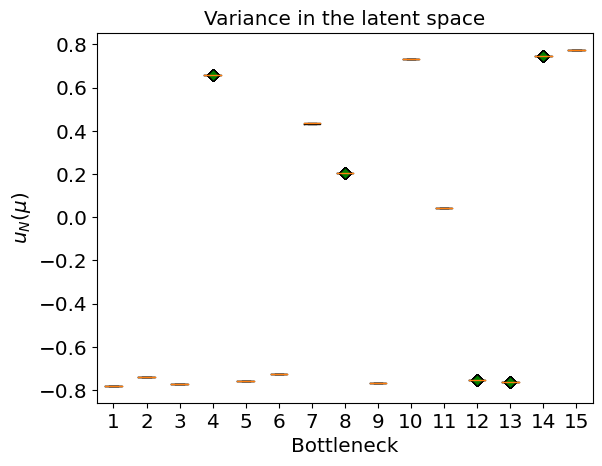

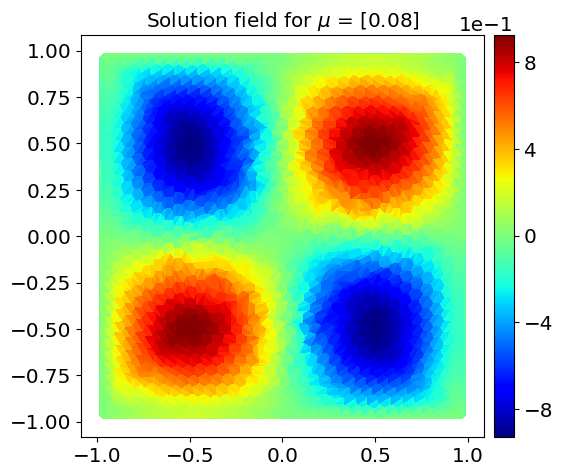

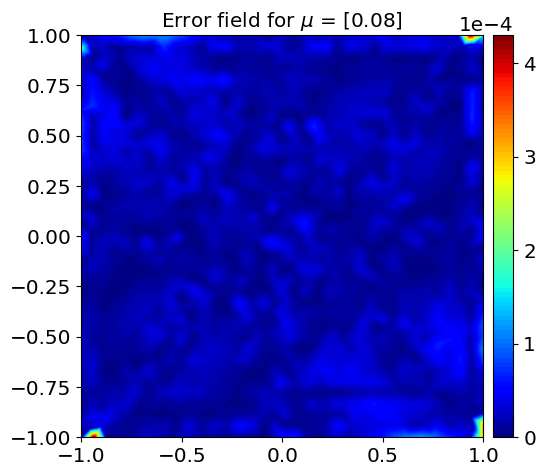

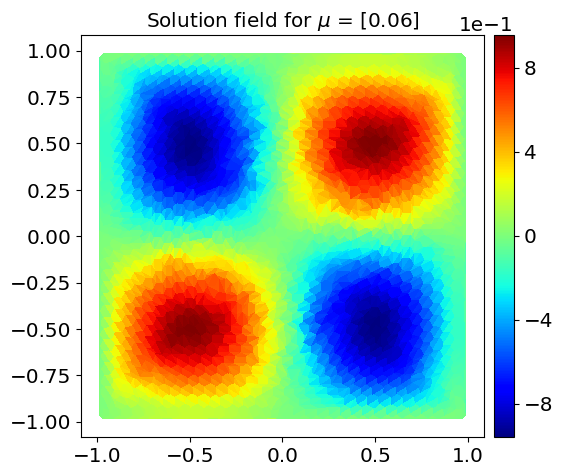

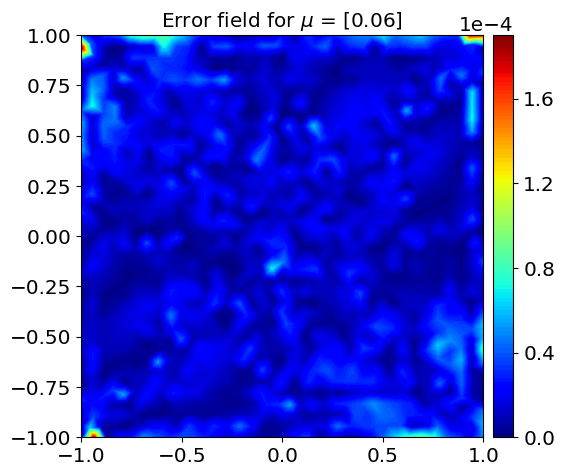

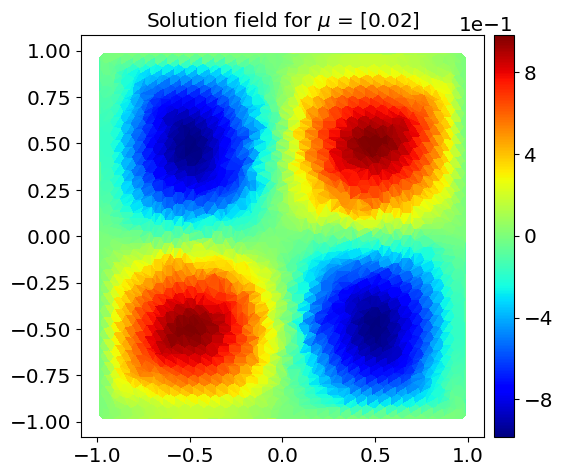

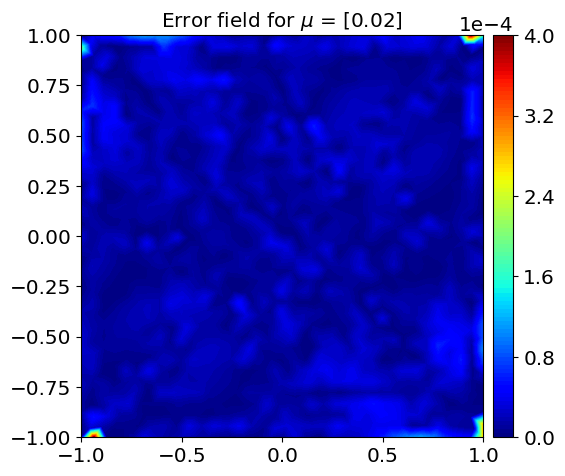

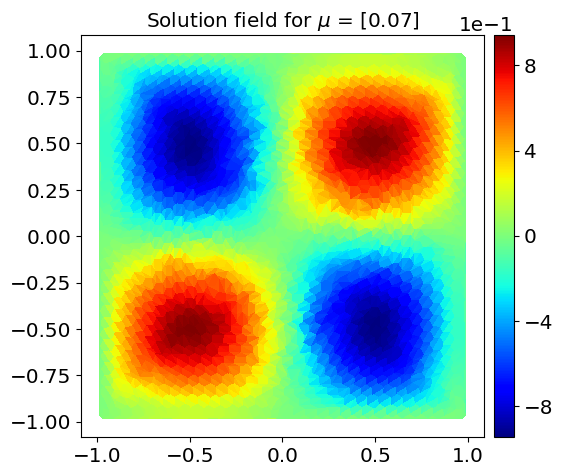

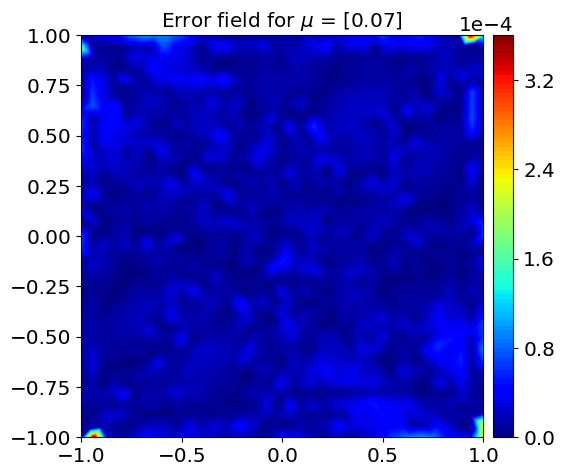

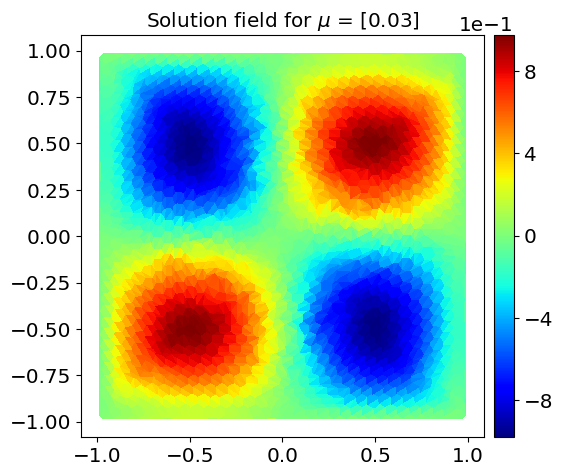

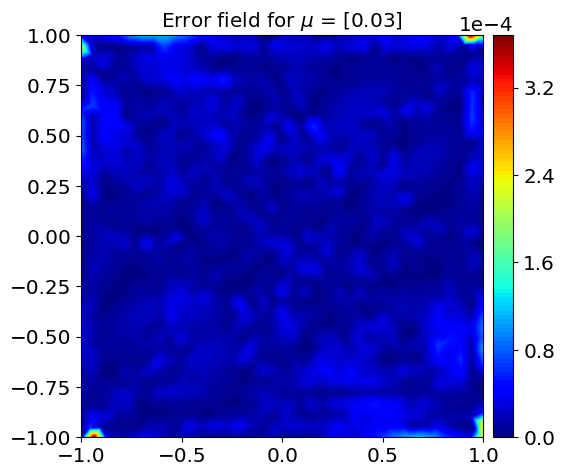

In [11]:
plotting.plot_loss(HyperParams)
plotting.plot_latent(HyperParams, latents_map, latents_gca)
#plotting.plot_error(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, dataset, vars)

N = 5
#snapshots = np.arange(params.shape[0]).tolist()
snapshots = np.arange(130).tolist() #sistemare
np.random.shuffle(snapshots)
for SNAP in snapshots[0:N]:
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, coordxyz, params)
    plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, coordxyz, params)

results_test, _, _ = testing.evaluate(VAR_test, model,dataset, val_loader, params, HyperParams, test_trajectories)

# Print the errors on the testing set

In [12]:
error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
error.print_error(error_abs, norm, vars)
error.save_error(error_abs, norm, HyperParams, vars)


Maximum absolute error for field GCA-ROM-DG =  0.16804048306932692
Mean absolute error for field GCA-ROM-DG =  0.14674624214047405
Minimum absolute error for field GCA-ROM-DG =  0.12730941225637188

Maximum relative error for field GCA-ROM-DG =  0.0036090210728739647
Mean relative error for field GCA-ROM-DG =  0.0031524414004343478
Minimum relative error for field GCA-ROM-DG =  0.002735152189980366


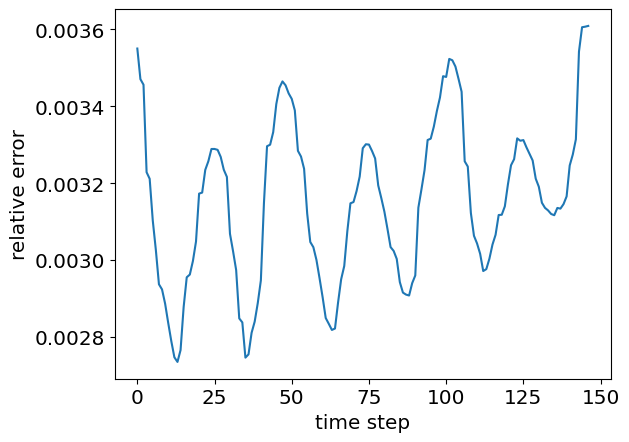

In [13]:

# when just one parameter
import matplotlib.pyplot as plt
plt.plot(np.array(error_abs)/np.array(norm))
plt.xlabel('time step')
plt.ylabel('relative error')
plt.show()

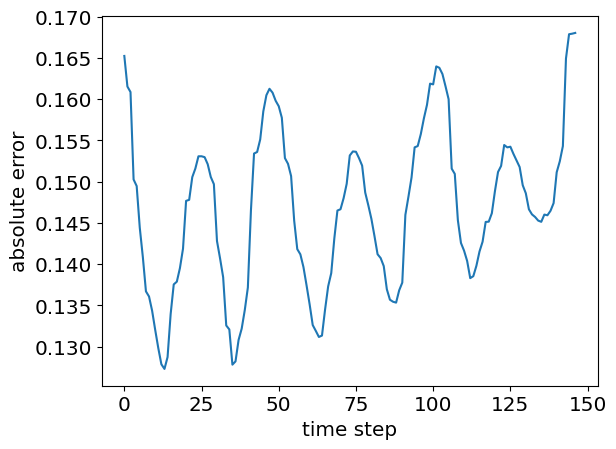

In [14]:
plt.plot(np.array(error_abs))
plt.xlabel('time step')
plt.ylabel('absolute error')
plt.show()

In [15]:
import shutil
shutil.make_archive('maxwelldgp1', 'zip', 'maxwelldgp1')

'/content/maxwelldgp1.zip'

In [16]:
'/content/maxwellp1.zip'

from google.colab import files
files.download('maxwelldgp1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from gca_rom_dg import scaling
from collections import defaultdict
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def plot_fields_var(SNAP, VAR_all, scaler_all, HyperParams, dataset, xyz,coordxyz, params):
    """
    Plots the field solution for a given snapshot.

    The function takes in the following inputs:

    SNAP: integer value indicating the snapshot to be plotted.
    results: array of shape (num_samples, num_features), representing the network's output.
    scaler_all: instance of the scaler used to scale the data.
    HyperParams: instance of the Autoencoder parameters class containing information about the network architecture and training.
    dataset: array of shape (num_samples, 3), representing the triangulation of the spatial domain.
    xyz: list of arrays of shape (num_samples, num_features), containing the x, y and z-coordinates of the domain.
    params: array of shape (num_features,), containing the parameters associated with each snapshot.
    The function generates a plot of the field solution and saves it to disk using the filepath specified in HyperParams.net_dir.
    """
    dof = int(dataset.dof)
    VAR = VAR_all.reshape(VAR_all.shape[0],int(VAR_all.shape[1]/dof),dof)
    fig = plt.figure()
    Z_net = scaling.inverse_scaling(VAR, scaler_all, HyperParams.scaling_type)
    z_net = Z_net[:, SNAP]

    res = np.array(results)
    TT = np.array(dataset.T)


    coordxx = coordxyz[0]
    coordyy = coordxyz[1]

    z_avg = plotting.average_nodes(TT,res[SNAP,:],coordxx)

    xx = xyz[0]
    yy = xyz[1]
    if dataset.dim == 2:
        triang = np.asarray(dataset.T - 1)
        cmap = cm.get_cmap(name='jet', lut=None)
        gs1 = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs1[0, 0])
        cs = ax.tricontourf(coordxx[:, SNAP], coordyy[:, SNAP], triang, z_avg, 100, cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(cs, cax=cax)
    elif dataset.dim == 3:
        zz = xyz[2]
        ax = fig.add_subplot(projection='3d')
        cax = inset_axes(ax, width="5%", height="60%", loc="center left",
                         bbox_to_anchor=(1.15, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        cmap = cm.get_cmap(name='jet', lut=None)
        p = ax.scatter(xx[:, SNAP], yy[:, SNAP], zz[:, SNAP], c=z_net, cmap=cmap, linewidth=0.5)
        cbar = fig.colorbar(p, ax=ax, cax=cax)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.set_zlabel('$z$')
        ax.locator_params(axis='both', nbins=5)
    tick_locator = MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    plt.tight_layout()
    ax.set_aspect('equal', 'box')
    ax.set_title('Solution field for $\mu$ = '+str(np.around(params[SNAP].detach().numpy(), 2)))
    plt.savefig(HyperParams.net_dir+'field_solution_'+str(SNAP)+''+HyperParams.net_run+'.png', bbox_inches='tight', dpi=500)



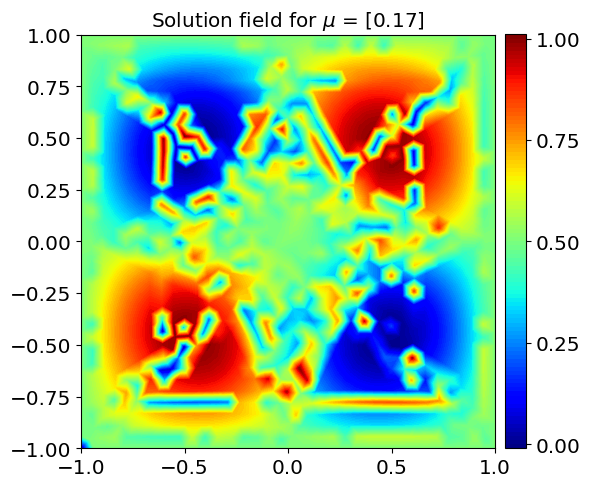

In [18]:
plot_fields_var(240, VAR_all, scaler_all, HyperParams, dataset, xyz,coordxyz, params)

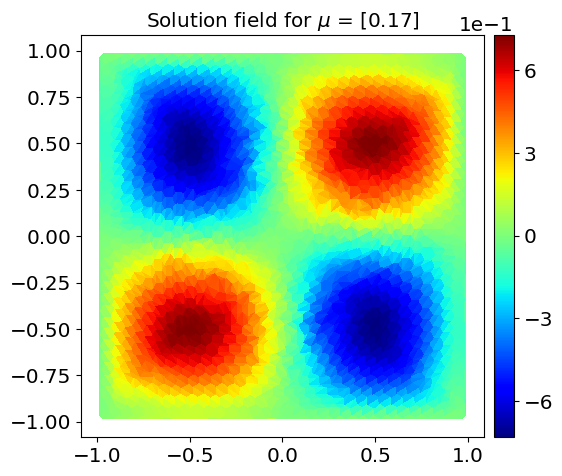

In [19]:
plotting.plot_fields(240, results, scaler_all, HyperParams, dataset, xyz, coordxyz, params)